# QUESTION 2b(OWN BUILT MODEL WITH ATTENTION GATE , NO INBUILT MODEL)

The assignment's second part involves a segmentation task on the given dataset. Participants are required to build models for the tasks and make the submission in the given format on the test set.

## Let's directly download the data set from kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c mlds-assignment-2

 97% 249M/256M [00:04<00:00, 91.5MB/s]
100% 256M/256M [00:04<00:00, 61.2MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/mlds-assignment-2.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Data Processing

### The provided image set has each image concatenated with their masks.Let's separate them

#### Separate color image from attached mask

In classification task we used the same data and saw that data is balanced.So no need to check again.

In [ ]:
import os
import cv2
import numpy as np
# Create a new folder to store sliced images
new_folder = "my_train_img"
os.makedirs(new_folder, exist_ok=True)
def rgb_to_gray(rgb_image):
    # Convert RGB image to grayscale
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    gray_image_3d = np.expand_dims(gray_image, axis=-1)
    return gray_image_3d
# Function to slice images columnwise
def slice_images(input_folder, output_folder, width=256):
    # Iterate through each image in the input folder
    for i in range(919):
        # Read the image
        img_path = os.path.join("train/train", f"Img_{i}.png")
        image = cv2.imread(img_path)

        # Slice the image columnwise
        sliced_image = image[:, 0:256, :]  # Taking only the first 256 columns
        #gray_image = rgb_to_gray(sliced_image)
        # Save the sliced image
        output_path = os.path.join(new_folder, f"Img_{i}.png")
        cv2.imwrite(output_path, sliced_image)

# Slice images in the specified folder and save them to the new folder
slice_images("train/train", new_folder)

#### Separate attached mask from color image

In [ ]:
import os
import cv2
import numpy as np
# Create a new folder to store sliced images
new_folder = "my_train_seg"
os.makedirs(new_folder, exist_ok=True)
def rgb_to_gray(rgb_image):
    # Convert RGB image to grayscale
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    gray_image_3d = np.expand_dims(gray_image, axis=-1)
    return gray_image_3d
# Function to slice images columnwise
def slice_images(input_folder, output_folder, width=256):
    # Iterate through each image in the input folder
    for i in range(919):
        # Read the image
        img_path = os.path.join("train/train", f"Img_{i}.png")
        image = cv2.imread(img_path)

        # Slice the image columnwise
        sliced_image = image[:, 256:, :]  # Taking only the last 256 columns
        #gray_image = rgb_to_gray(sliced_image)
        # Save the sliced image
        output_path = os.path.join(new_folder, f"Img_{i}.png")
        cv2.imwrite(output_path, sliced_image)

# Slice images in the specified folder and save them to the new folder
slice_images("train/train", new_folder)

## Import necessary libraries


In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import  plot_model ,Sequence
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy
from scipy.ndimage import morphology as mp



import os
from glob import glob  # for getting list paths of image and labels
from random import choice,sample
from matplotlib import pyplot as plt
import cv2 # saving and loading images

## Given masks are in RGB , so we need to change it to Gray

In [ ]:

def rgb_to_gray(rgb_image):
    # Convert RGB image to grayscale
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    gray_image_3d = np.expand_dims(gray_image, axis=-1)
    return gray_image_3d

## We can see currently images are with 3 channels

In [ ]:
# Load the RGB image
gray_image = cv2.imread('/content/my_train_seg/Img_0.png')

# Convert RGB image to grayscale
#gray_image = rgb_to_gray(rgb_image)
print(gray_image.shape)

(256, 256, 3)


## Create gray images and save in my_train_seg_grey

In [ ]:
import os
import cv2
import numpy as np

# Define the input and output directories
input_dir = "/content/my_train_seg"
output_dir = "/content/my_train_seg_grey"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Iterate through each image in the input directory
for filename in os.listdir(input_dir):
    # Read the image
    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img=np.expand_dims(gray_img, axis=-1)
    # Save the grayscale image to the output directory
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, gray_img)



## We can see our gray scale mask images has entries 0 and 1

In [ ]:
from PIL import Image

def image_to_matrix(image_path):
    # Open the image
    img = Image.open(image_path)

    # Convert the image to grayscale if needed
    img = img.convert('L')  # 'L' mode represents grayscale

    # Get the size of the image
    width, height = img.size

    # Get the pixel values as a list of tuples
    pixels = list(img.getdata())

    # Convert pixel values to a matrix representation
    matrix = [pixels[i * width:(i + 1) * width] for i in range(height)]

    return matrix

# Example usage:
image_path = '/content/my_train_seg_grey/Img_0.png'
matrix_representation = image_to_matrix(image_path)
print(matrix_representation)


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Let's create training data with color images and their corresponding gray-scaled masks

In [ ]:
train_img_dir = '/content/my_train_img/'
train_mask_dir = '/content/my_train_seg_grey/'
train_imgs = os.listdir(train_img_dir)
train_masks = os.listdir(train_mask_dir)
train_imgs= sorted([ i for i in train_imgs ])# We need to do sorting so that corresponding images and their mask stay in the samre place in sorted list of their corresponding directory
train_masks= sorted([ i for i in train_masks ])
print(len(train_imgs))
print(len(train_masks))


919
919


## We can see color images and their mask are in same index

In [ ]:
print(train_imgs[:3])
train_masks[:3]

['Img_0.png', 'Img_1.png', 'Img_10.png']


['Img_0.png', 'Img_1.png', 'Img_10.png']

## We will do training and validation split of our training data with 80:20

In [ ]:
from sklearn.model_selection import train_test_split

val_img_dir =  train_img_dir
val_mask_dir = train_mask_dir


train_imgs,val_imgs,train_masks,val_masks =  train_test_split(train_imgs, train_masks, test_size=0.2, random_state=42)


print(len(train_masks))
print(len(val_masks))

735
184


# Here we impliment keras custom data generator to get batch images and labels without loading whole dataset in the active memory

In [ ]:
from scipy.ndimage import binary_erosion, binary_dilation


class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, images,image_dir,labels,label_dir ,batch_size=16, dim=(256,256,3) ,shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.image_dir = image_dir
        self.labels = labels
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:

            # Store sample
            img = load_img(self.image_dir + self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.

            batch_imgs.append(img)
           # Store class
            label = load_img(self.label_dir + self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0

            label = binary_erosion(binary_erosion(label))
            label = binary_dilation(binary_dilation(binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)

        return np.array(batch_imgs,dtype = np.float32 ) ,np.array(batch_labels , dtype = np.float32 )

In [ ]:
train_generator = DataGenerator(train_imgs,train_img_dir,train_masks,train_mask_dir,batch_size=30, dim=(256,256,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps# We applied batch size of 30, and getting number of step at every epoch

24

## Let's validate whether in training data image and it's corresponding mask is in same index or not.

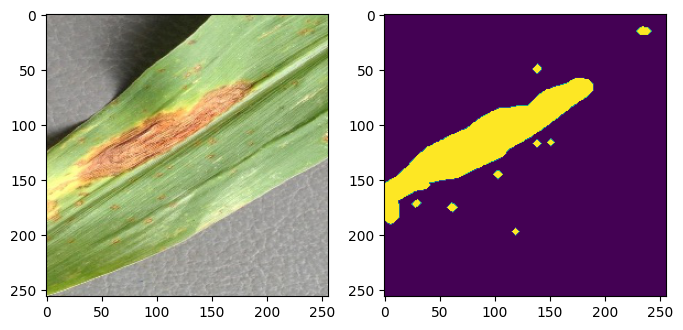

In [ ]:
X,y = train_generator.__getitem__(1)
t = 12

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[t])
plt.subplot(122)
plt.imshow(np.reshape(y[t]/1.,(256,256)))


## Let's validate the same for validation data set

In [ ]:
val_generator = DataGenerator(val_imgs,val_img_dir,val_masks,val_mask_dir,batch_size=30, dim=(256,256,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

6

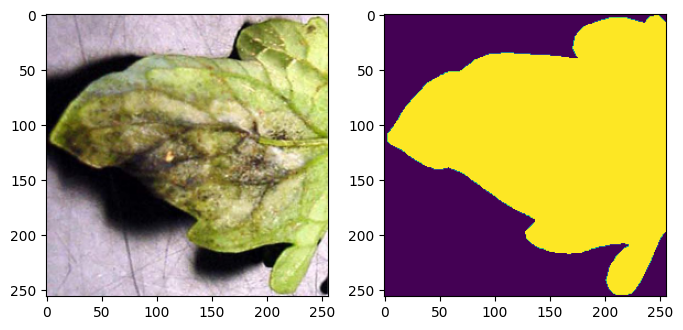

In [ ]:
P,q = val_generator.__getitem__(1)
t = 0

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(P[t])
plt.subplot(122)
#print(q[t])
plt.imshow(np.reshape(q[t],(256,256)))

# MODEL: UNET ( NO PRETRAINED MODEL.BUILT OWN MODEL WITH ATTENTION MECHANISM)

Previously I was doing without data augmentation, but model was not becoming able to generalize more(validation dice coefficient was less).Used data augmentation then.Faced over-fitting afterwards.That's why implemented dropout.

Then also model was not giving good validation score.Implemented **attention gate** to it improved the score.

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, MaxPooling2D, Dropout, concatenate, Input,Add,Multiply
from tensorflow.keras.models import Model
from keras.layers import UpSampling2D

def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y

def attention_gate(input_tensor, g, inter_channel):
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)
    phi_g = UpSampling2D(size=(2, 2))(phi_g)  # Upsample phi_g to match spatial dimensions of theta_x
    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = Multiply()([input_tensor, rate])
    return att_x

def Unet(h, w, filters):
    # down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.25)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.4)(conv5)

    # attention gates
    att4 = attention_gate(conv4, conv5, conv4.shape[-1] // 2)
    deconv6 = deconv_block(conv5, residual=att4, nfilters=filters*8)
    deconv6 = Dropout(0.25)(deconv6)

    att3 = attention_gate(conv3, deconv6, conv3.shape[-1] // 2)
    deconv7 = deconv_block(deconv6, residual=att3, nfilters=filters*4)
    deconv7 = Dropout(0.25)(deconv7)

    att2 = attention_gate(conv2, deconv7, conv2.shape[-1] // 2)
    deconv8 = deconv_block(deconv7, residual=att2, nfilters=filters*2)

    att1 = attention_gate(conv1, deconv8, conv1.shape[-1] // 2)
    deconv9 = deconv_block(deconv8, residual=att1, nfilters=filters)

    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [ ]:
model = Unet(256 , 256 , 64)

## Here is the summary of our  model

In [ ]:
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['image_input[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

## Defined Jaccard_distance loss, dice_coef.

Tested with BCE loss but was not a good choice of loss for our  model.That's why implemented Jaccard_distance_loss as our loss function

In [ ]:
def jaccard_distance_loss(y_true, y_pred,smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import keras
import numpy as np
)
optimizer = keras.optimizers.Adam(learning_rate=0.0002)

Again as usual check-point,Early stopping has been introduced.

In [ ]:
model.compile(optimizer=optimizer, loss=jaccard_distance_loss ,metrics = [dice_coef, 'accuracy'])
mc = ModelCheckpoint(mode='max', filepath='top.weights.h5', monitor='val_dice_coef',save_best_only='True', save_weights_only='True', verbose=1)# MODE=MAX BECAUSE WE WANT TO MAXIMIZE THE DICE COEFFICIENT
es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=40, verbose=1,restore_best_weights=True)
callbacks = [mc,es]
model.metrics_names

[]

In [ ]:
results = model.fit(train_generator, steps_per_epoch=train_steps,epochs=300,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

Epoch 1/300
24/24 [==============================] - ETA: 0s - loss: 0.2263 - dice_coef: 0.1834 - accuracy: 0.8663
Epoch 1: val_dice_coef improved from -inf to 0.16179, saving model to top.weights.h5
24/24 [==============================] - 151s 3s/step - loss: 0.2263 - dice_coef: 0.1834 - accuracy: 0.8663 - val_loss: 0.9016 - val_dice_coef: 0.1618 - val_accuracy: 0.0897
Epoch 2/300
24/24 [==============================] - ETA: 0s - loss: 0.1360 - dice_coef: 0.1757 - accuracy: 0.9070
Epoch 2: val_dice_coef improved from 0.16179 to 0.17144, saving model to top.weights.h5
24/24 [==============================] - 66s 3s/step - loss: 0.1360 - dice_coef: 0.1757 - accuracy: 0.9070 - val_loss: 0.8380 - val_dice_coef: 0.1714 - val_accuracy: 0.1675
Epoch 3/300
24/24 [==============================] - ETA: 0s - loss: 0.1178 - dice_coef: 0.1563 - accuracy: 0.9154
Epoch 3: val_dice_coef improved from 0.17144 to 0.18790, saving model to top.weights.h5
24/24 [==============================] - 70s 3s

We got val_dice_coef=0.64, and train_dice_coef=0.76 at 85th epoch

Let's download the learnt weight

In [ ]:
from google.colab import files

files.download('/content/top.weights.h5')


In [ ]:
results.history.keys()

In [ ]:
loss = results.history["loss"]
val_loss = results.history["val_loss"]

dice_coef = results.history["dice_coef"]
val_dice_coef = results.history["val_dice_coef"]

acc = results.history["accuracy"]
val_acc = results.history["val_accuracy"]

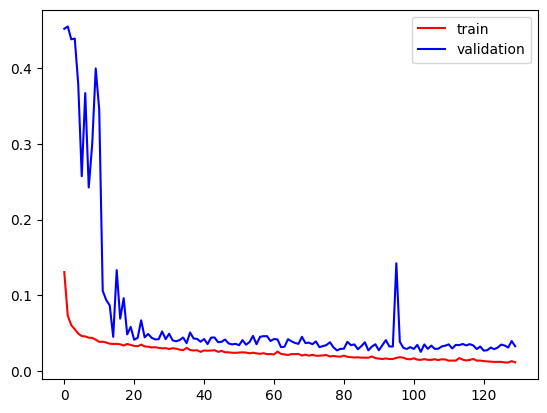

In [ ]:
import matplotlib.pyplot as plt

plt.plot(results.history['loss'],color='red',label='train')
plt.plot(results.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

A very good training curve

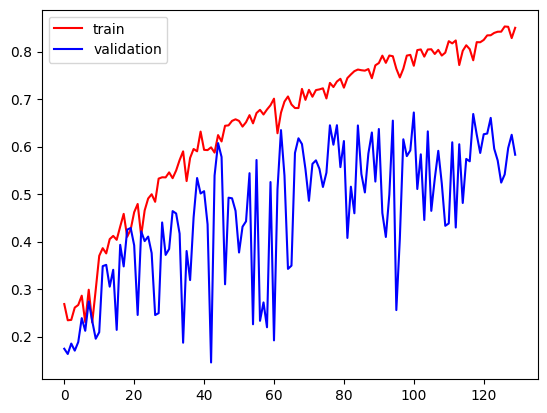

In [ ]:
import matplotlib.pyplot as plt

plt.plot(results.history['dice_coef'],color='red',label='train')
plt.plot(results.history['val_dice_coef'],color='blue',label='validation')
plt.legend()
plt.show()

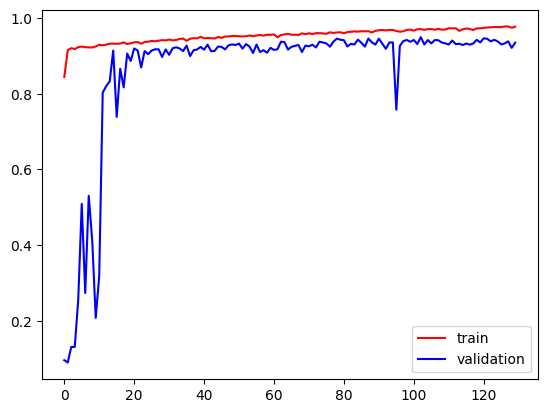

In [ ]:
import matplotlib.pyplot as plt

plt.plot(results.history['accuracy'],color='red',label='train')
plt.plot(results.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:


# Load weights from the saved file, allowing partial loading
model.load_weights('top.weights.h5')

## Let's see the predictions

In [ ]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)

    mask = (mask[0] > 0.5)*1
#     print(np.unique(mask,return_counts=True))
    mask = np.reshape(mask,(256,256))
    return mask

(256, 256, 3)

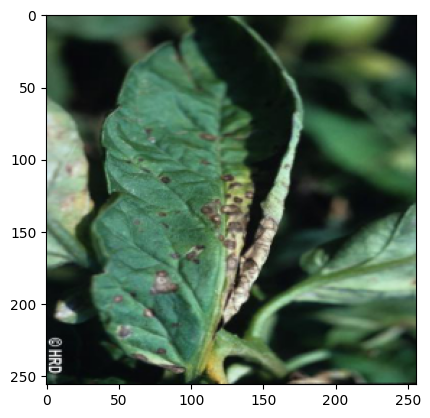

In [ ]:
image = "/content/my_train_img/Img_0.png"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

## Predicted Mask

1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 3)


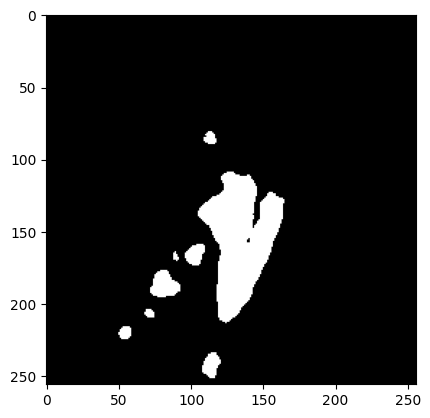

In [ ]:
Mask = make_prediction(model,image,(256,256,3))
mask2 = cv2.merge([Mask,Mask,Mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
# print(mask.shape)
plt.imshow(mask2)

In [ ]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(Mask*1),(w,h))
mask_resized = mask_resized != 0
#print(np.unique(mask_resized,return_counts=True))
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]


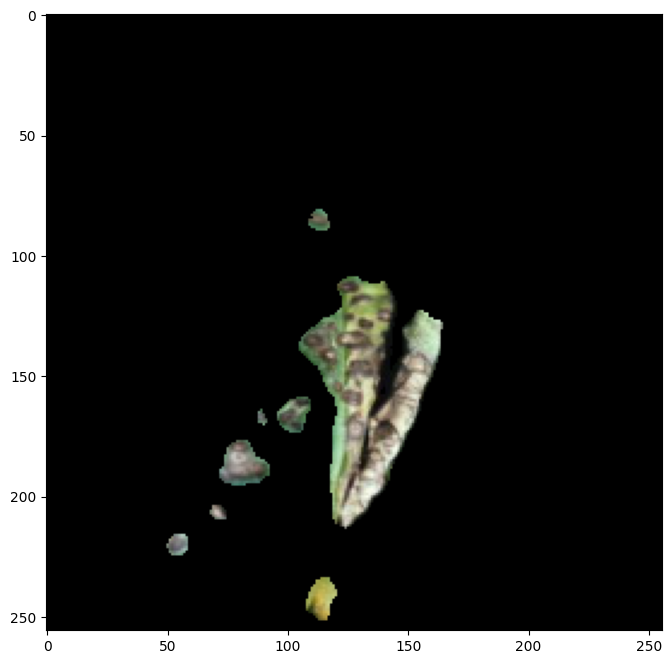

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)

## Our mask is of one dimensional.We will concatenate them 3 times before passing it through mask2rle for final submission

In [ ]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,256)):
    #mask_rle: run-length as string formated (start length)
    #shape: (width,height) of array to return
    #Returns numpy array, 1 - mask, 0 - background
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

Here is the predicted rle of above mask

In [ ]:
mask2 = cv2.merge([Mask,Mask,Mask]).astype('float32')
Mask2rle=mask2rle(mask2)
print((Mask2rle))

13021 2 13275 6 13530 8 13785 9 14041 9 14297 9 14553 9 14809 8 15066 6 17615 2 17869 5 18125 6 18381 6 18622 4 18637 6 18877 6 18894 5 19128 12 19151 4 19381 15 19636 16 19891 18 20147 18 20402 19 20658 19 20914 19 21170 19 21426 18 21683 17 21941 15 22199 13 22457 11 22694 5 22713 11 22949 6 22970 9 23207 5 23226 8 23465 2 23483 6 23740 5 24742 4 24997 7 25252 9 25507 11 25762 12 26017 14 26273 14 26529 14 26784 15 27017 4 27040 15 27271 7 27296 14 27526 9 27552 11 27781 11 27808 7 27892 5 27990 3 28036 13 28065 5 28145 9 28244 1 28246 4 28291 15 28399 11 28499 7 28547 16 28654 13 28754 9 28802 17 28908 16 29010 9 29057 20 29164 17 29266 9 29312 23 29419 18 29523 8 29567 27 29675 18 29780 7 29823 29 29931 18 30039 3 30079 31 30187 16 30334 33 30396 12 30445 9 30590 34 30636 39 30702 6 30845 39 30888 45 30960 3 31089 3 31100 89 31344 6 31355 91 31599 103 31855 104 32110 104 32366 104 32622 103 32878 102 33134 101 33391 100 33648 98 33904 97 34160 96 34417 93 34673 91 34929 90 35185 89

(256, 256, 3)

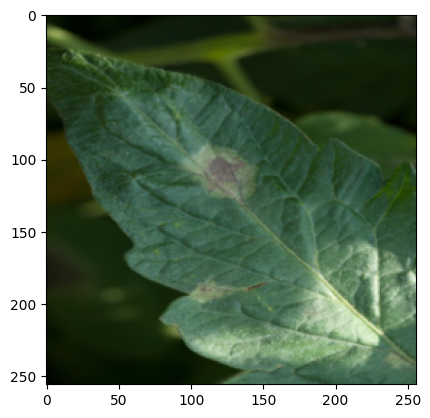

In [ ]:
image = "/content/my_train_img/Img_1.png"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

1/1 [==============================] - 0s 37ms/step
(256, 256, 3) (256, 256, 3)


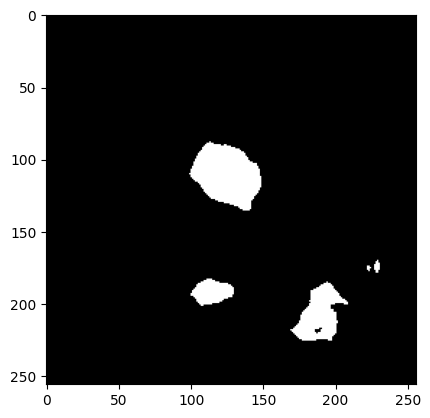

In [ ]:
mask = make_prediction(model,image,(256,256,3))
mask2 = cv2.merge([mask,mask,mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
# print(mask.shape)
plt.imshow(mask2)

In [ ]:
print(mask2rle(mask2))

25455 1 25708 6 25794 2 25962 9 26048 4 26215 13 26303 6 26469 16 26558 8 26723 18 26812 12 26977 21 27067 14 27232 23 27323 15 27487 26 27578 17 27741 29 27834 17 27996 32 28089 17 28251 34 28345 17 28506 36 28600 18 28762 37 28856 18 29017 39 29112 18 29274 39 29368 18 29530 39 29625 16 29787 38 29881 16 30043 39 30138 15 30299 39 30394 15 30555 40 30650 15 30811 40 30907 13 31068 39 31163 13 31324 39 31419 12 31579 41 31675 11 31835 41 31931 11 32092 40 32187 11 32348 40 32444 9 32604 41 32700 9 32861 40 32957 8 33117 40 33214 5 33373 41 33630 40 33886 40 34142 41 34399 41 34656 40 34912 41 35169 40 35427 38 35684 37 35942 35 36199 33 36455 27 36712 25 36968 23 37224 22 37482 19 37740 15 38001 8 43483 1 43739 2 43994 4 44249 6 44504 8 44759 10 45013 13 45265 17 45519 20 45774 21 46029 22 46284 23 46539 24 46791 1 46793 26 47040 35 47296 35 47551 36 47807 28 47837 6 48062 29 48094 4 48318 29 48349 5 48573 29 48605 5 48828 30 48859 7 49084 38 49339 39 49595 39 49850 40 50107 40 50363 

In [ ]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
mask_resized = mask_resized != 0
#print(np.unique(mask_resized,return_counts=True))
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]


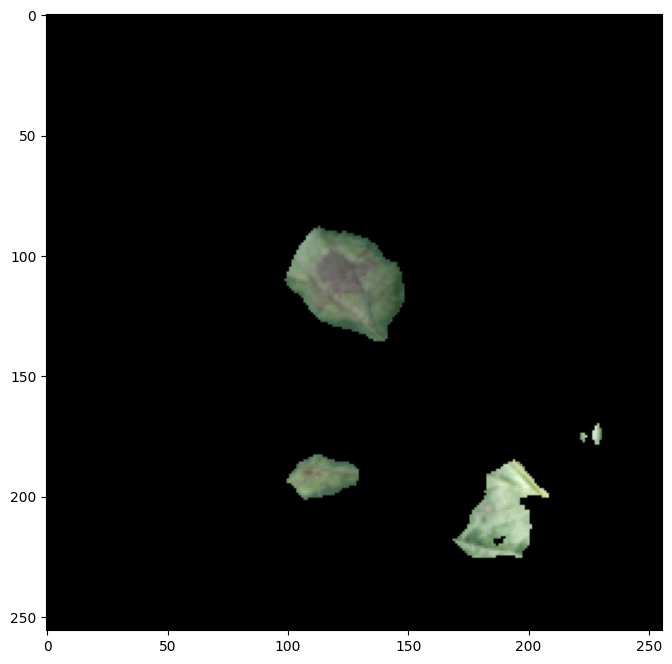

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)

In [ ]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,256)):
    #mask_rle: run-length as string formated (start length)
    #shape: (width,height) of array to return
    #Returns numpy array, 1 - mask, 0 - background
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

# Prediction

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img

# Load the trained model
#model.load_weights('/content/top-weights.h5')
#model1.load_weights('/content/model1_top-weights_classification.h5')
#model2.load_weights('/content/model2_top-weights_classification.h5')

# Load the test dataset from the CSV file
test_df = pd.read_csv('test.csv')
test_folder = 'test/test'
test_files = os.listdir(test_folder)
# Initialize an empty list to store the binary predictions
binary_predictions = []

# Iterate through the rows of the test dataset
for index, row in test_df.iterrows():
    # Load the image corresponding to the 'id' column
    #img = load_img(row['id'], target_size=(256, 256))  # Assuming images are in the current directory
    image_path = os.path.join(test_folder, row['id'])
    image =f"/content/test/test/{row['id']}"
    #image = cv2.resize(image, (256, 256))
    mask = make_prediction(model,image,(256,256,3))
    #image = image / 255.0  # Normalize pixel values
    mask2 = cv2.merge([mask,mask,mask]).astype('float32')
    mask2 = cv2.resize(mask2,(256,256))

    #OUR CLASSIFICATION MODEL WAS GIVING MORE F1 SCORE, SO WE CAN BELIEVE CLASSIFICATION MODEL.wE WILL PREDICT RLE WITH SEGMENTATION MODEL WHEN CLASSIFICATION MODEL TELLS IT IS DISEASED IMAGE 
    if test_df.at[index,'binary_pred']==0:
      test_df.at[index,'segmentation_pred']= 'Healthy'
    else:
      test_df.at[index,'segmentation_pred']=mask2rle(mask2) if mask2rle(mask2) !='' else 'Healthy'
# Save the updated test dataset back to the CSV file
test_df.to_csv('test_with_predictions.csv', index=False)

